# 😴 24-Hour Sleep Timeline 💤
<p align="center">
  <img src="imgs/data_dreaming.png" alt="24-Hour Sleep Timeline EDA" width="400"/>
</p>

## 📦 Imports

In [1]:
import json
import gzip
import pandas as pd
from datetime import datetime, timedelta
import boto3
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns

## 📥 Data Import Functions

In [2]:
def parse_fitbit_data(data):
    """Parse the list of measurements into separate DataFrames by measurement type"""
    
    # Group data by measurement type
    measurements_dict = {}
    for record in data:
        measurement = record['measurement']
        if measurement not in measurements_dict:
            measurements_dict[measurement] = []
        measurements_dict[measurement].append(record)
    
    # Convert each measurement type to a DataFrame
    dfs = {}
    
    for measurement, records in measurements_dict.items():
        parsed_records = []
        for record in records:
            flat_record = {
                'time': pd.to_datetime(record['time']),
            }
            
            # Add all tags
            if 'tags' in record:
                for tag_key, tag_value in record['tags'].items():
                    flat_record[tag_key] = tag_value
            
            # Add all fields
            if 'fields' in record:
                flat_record.update(record['fields'])
            
            parsed_records.append(flat_record)
        
        # Create DataFrame
        df = pd.DataFrame(parsed_records)
        df = df.sort_values('time').reset_index(drop=True)
        
        dfs[measurement] = df
    
    return dfs

In [3]:
def get_fitbit_data_for_date(date_str):
    """
    Fetch Fitbit data for a specific date from S3.
    
    Args:
        date_str: Date in format 'YYYY-MM-DD'
    
    Returns:
        dict: Dictionary of DataFrames by measurement type
    """
    # Parse the date
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Date must be in format 'YYYY-MM-DD'")
    
    # Build the file key with your actual naming convention
    file_key = f"cromwell/fitbit/fitbit_backup_{date.strftime('%Y-%m-%d')}.json.gz"
    
    print(f"📥 Fetching data for {date.strftime('%Y-%m-%d')} from S3...")
    print(f"   File: {file_key}")
    
    # Fetch from S3
    bucket_name = 'followcrom'
    session = boto3.Session(profile_name='surface')
    s3 = session.client('s3')
    
    try:
        response = s3.get_object(Bucket=bucket_name, Key=file_key)
        with gzip.GzipFile(fileobj=BytesIO(response['Body'].read())) as f:
            data = json.load(f)
        
        print(f"✅ Loaded {len(data)} records")
        
        # Parse all data
        dfs = parse_fitbit_data(data)
        
        print(f"📊 Found {len(dfs)} measurement types:")
        for measurement, df in dfs.items():
            print(f"   - {measurement}: {len(df)} records")
        
        return dfs
        
    except s3.exceptions.NoSuchKey:
        print(f"❌ No data found for {date.strftime('%Y-%m-%d')}")
        print(f"   File not found: {file_key}")
        return None
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return None

## 🎨 Sleep Analysis Constants & Configuration

In [4]:
# Color scheme for sleep stages
SLEEP_COLORS = {
    'Deep': '#0f172a',      # Midnight Navy — deep and restful
    'Light': '#a5d8ff',     # Pastel Blue — gentle and calming
    'REM': '#c084fc',       # Soft Lavender — dreamy and ethereal
    'Awake': '#fde047'      # Butter Yellow — bright but soft
}

TIMEZONE = 'Europe/London'

# Map numeric levels to names
level_decode = {
    0: 'Deep',
    1: 'Light',
    2: 'REM',
    3: 'Awake'
}

## 🔧 Helper Functions

In [5]:
def _get_main_sleep_session(df_summary):
    """Extract the main sleep session from summary dataframe."""
    if df_summary.empty:
        return None
    
    summary = df_summary.copy()
    if 'isMainSleep' in summary.columns:
        main_sleep = summary[summary['isMainSleep'] == 'True']
        if not main_sleep.empty:
            summary = main_sleep
    
    return summary.iloc[0]

In [6]:
def _prepare_sleep_data(df_levels, df_summary, start_time, end_time):
    """
    Prepare sleep level data for a 24-hour window.
    Adds Awake periods at the start, between sessions, and at the end.
    """
    # Convert all level times to local timezone
    levels = df_levels.copy()
    levels['time'] = levels['time'].dt.tz_convert(TIMEZONE)
    levels['end_time'] = levels['end_time'].dt.tz_convert(TIMEZONE)
    
    # Filter levels for this time window
    levels = levels[
        (levels['time'] >= start_time) & 
        (levels['time'] < end_time)
    ].copy()
    
    if levels.empty:
        return levels
    
    # Sort by time
    levels = levels.sort_values('time').reset_index(drop=True)
    
    # Get all sleep sessions from summary (converted to local timezone)
    summary = df_summary.copy()
    summary['time'] = summary['time'].dt.tz_convert(TIMEZONE)
    summary['end_time'] = summary['end_time'].dt.tz_convert(TIMEZONE)
    
    # Sort sessions by start time
    summary = summary.sort_values('time').reset_index(drop=True)
    
    gaps_to_add = []
    
    # Add Awake period from midnight to first sleep session
    if not summary.empty:
        first_session_start = summary['time'].min()
        
        if start_time < first_session_start:
            gap_seconds = (first_session_start - start_time).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                # print(f"   ⚠️  Adding Awake before first session: {gap_seconds/60:.1f} min ({start_time.strftime('%H:%M')} to {first_session_start.strftime('%H:%M')})")
                
                gaps_to_add.append({
                    'time': start_time,
                    'end_time': first_session_start,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # For each sleep session, check if stages data ends before session end_time
    for idx, session in summary.iterrows():
        session_start = session['time']
        session_end = session['end_time']
        session_type = "NAP" if session.get('isMainSleep') == 'False' else "MAIN SLEEP"
        
        # Get stages for this session
        session_stages = levels[
            (levels['time'] >= session_start) & 
            (levels['time'] < session_end)
        ]
        
        if not session_stages.empty:
            last_stage_end = session_stages['end_time'].max()
            
            # If stages end before session end, add Awake period
            if last_stage_end < session_end:
                gap_seconds = (session_end - last_stage_end).total_seconds()
                
                if gap_seconds > 30:  # More than 30 seconds
                    # print(f"   ⚠️  Adding Awake at end of {session_type}: {gap_seconds/60:.1f} min ({last_stage_end.strftime('%H:%M')} to {session_end.strftime('%H:%M')})")
                    
                    gaps_to_add.append({
                        'time': last_stage_end,
                        'end_time': session_end,
                        'level': 3.0,
                        'level_name': 'Awake',
                        'duration_seconds': gap_seconds,
                        'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                    })
    
    # Find gaps BETWEEN sessions (awake time between nap and main sleep, etc.)
    for i in range(len(summary) - 1):
        current_session_end = summary.iloc[i]['end_time']
        next_session_start = summary.iloc[i + 1]['time']
        
        if current_session_end < next_session_start:
            gap_seconds = (next_session_start - current_session_end).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                # print(f"   ⚠️  Adding Awake between sessions: {gap_seconds/60:.1f} min ({current_session_end.strftime('%H:%M')} to {next_session_start.strftime('%H:%M')})")
                
                gaps_to_add.append({
                    'time': current_session_end,
                    'end_time': next_session_start,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # Add Awake period from last session end to midnight (end_time)
    if not summary.empty:
        last_session_end = summary['end_time'].max()
        
        if last_session_end < end_time:
            gap_seconds = (end_time - last_session_end).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                # print(f"   ⚠️  Adding Awake after last session to midnight: {gap_seconds/60:.1f} min ({last_session_end.strftime('%H:%M')} to {end_time.strftime('%H:%M')})")
                
                gaps_to_add.append({
                    'time': last_session_end,
                    'end_time': end_time,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # Add all gaps
    if gaps_to_add:
        levels = pd.concat([levels, pd.DataFrame(gaps_to_add)], ignore_index=True)
        levels = levels.sort_values('time').reset_index(drop=True)
    
    return levels

In [79]:
def _plot_sleep_bars(ax, levels):
    seen_labels = set()

    for idx, row in levels.iterrows():
        stage = row['level_name']
        color = SLEEP_COLORS.get(stage, '#cccccc')
        duration_hours = row['duration_seconds'] / 3600
        
        label = stage if stage not in seen_labels else None
        seen_labels.add(stage)

        ax.barh(
            y=0,
            width=duration_hours,
            left=row['time'],
            height=0.8,
            color=color,
            edgecolor='white',
            linewidth=0.5,
            alpha=0.9,
            label=label
        )

In [8]:
def _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15):
    """Apply common formatting to timeline axis."""
    # Create a formatter that's timezone-aware
    formatter = DateFormatter('%H:%M', tz=start_time.tz)
    ax.xaxis.set_major_formatter(formatter)
    
    # Use HourLocator for cleaner intervals in 24-hour view
    if interval_minutes >= 60:
        ax.xaxis.set_major_locator(HourLocator(interval=interval_minutes//60, tz=start_time.tz))
    else:
        ax.xaxis.set_major_locator(MinuteLocator(interval=interval_minutes, tz=start_time.tz))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax.set_xlim(start_time, end_time)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    ax.grid(True, axis='x', alpha=0.3, linestyle='--')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [9]:
def _add_sleep_legend(ax, location='upper right'):
    """Add standard sleep stage legend to axis."""
    legend_elements = [
        mpatches.Patch(facecolor=SLEEP_COLORS['Deep'], label='Deep', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['Light'], label='Light', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['REM'], label='REM', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['Awake'], label='Awake', edgecolor='white')
    ]
    ax.legend(handles=legend_elements, loc=location, ncol=4, fontsize=11, framealpha=0.9)

## 📊 Main Plotting Functions

In [125]:
def plot_sleep_timeline(df_levels, df_summary):
    """Plot a horizontal timeline showing sleep stages throughout a 24-hour period."""

    if df_levels.empty or df_summary.empty:
        print(f"❌ No sleep data found")
        return None

    # Get the main sleep session to determine the date and window
    main_sleep = df_summary[df_summary.get('isMainSleep', 'True') == 'True']
    if main_sleep.empty:
        main_sleep = df_summary.iloc[[0]]  # Fallback to first session

    main_sleep_start = main_sleep.iloc[0]['time']
    sleep_date = main_sleep_start.date()
    sleep_hour = main_sleep_start.hour

    # Extract actual end time for display + title
    main_sleep_end = (
        main_sleep.iloc[0].get("endTime") or
        main_sleep.iloc[0].get("end_time") or
        None
    )
    if main_sleep_end is not None:
        main_sleep_end = pd.to_datetime(main_sleep_end)

    # Smart window selection based on main sleep start time
    if sleep_hour < 18:  # Sleep starts before 6 PM (shift work pattern)
        start_time = pd.Timestamp(sleep_date, tz=TIMEZONE)  # 00:00
        end_time = start_time + pd.Timedelta(days=1)        # Next day 00:00
        window_type = "midnight-to-midnight"
    else:
        start_time = pd.Timestamp(sleep_date, tz=TIMEZONE) + pd.Timedelta(hours=12)  # Noon
        end_time = start_time + pd.Timedelta(days=1)                                  # Next noon
        window_type = "noon-to-noon"

    # Console summary
    if window_type == "noon-to-noon":
        day1 = start_time.date()
        day2 = end_time.date()
        print(f"   📅 Date: {day1.strftime('%A %dth %B %Y')} → {day2.strftime('%A %dth %B %Y')}")
    else:
        print(f"   📅 Date: {sleep_date.strftime('%A %dth %B %Y')}")

    print(f"   🌙 From: {main_sleep_start.strftime('%H:%M')}")

    if main_sleep_end is not None:
        print(f"   ☀️ To:   {main_sleep_end.strftime('%H:%M')}\n")
    else:
        print(f"   ☀️ To:   {end_time.strftime('%H:%M')}\n")

    # Prepare data - includes all sessions and inserted Awake periods
    levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)
    if levels.empty:
        print(f"❌ No sleep level data found for this period")
        return None

    fig, ax = plt.subplots(figsize=(16, 4))
    _plot_sleep_bars(ax, levels)

    # --- Add "To Bed" and "Up" markers on the timeline ---
    start_marker = main_sleep_start
    end_marker = main_sleep_end

    ax.axvline(start_marker, linestyle="--", linewidth=1.2)
    ax.text(
        start_marker,
        1.05,
        "To Bed",
        ha="center",
        va="bottom",
        fontsize=10,
        transform=ax.get_xaxis_transform()
    )

    if end_marker is not None:
        ax.axvline(end_marker, linestyle="--", linewidth=1.2)
        ax.text(
            end_marker,
            1.05,
            "Up",
            ha="center",
            va="bottom",
            fontsize=10,
            transform=ax.get_xaxis_transform()
        )

    if window_type == "noon-to-noon":
        day1 = start_time.date()
        day2 = end_time.date()
        title = (
            f'{window_type.title()} Sleep Timeline for '
            f'{day1.strftime("%A %dth %B")} → {day2.strftime("%A %dth %B")}\n'
        )
    else:
        title = (
            f'{window_type.title()} Sleep Timeline for '
            f'{sleep_date.strftime("%A %dth %B")}\n'
        )

    _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=60)

    # --- Add sleep legend at correct position ---
    legend_loc = "upper left" if window_type == "noon-to-noon" else "upper right"
    _add_sleep_legend(ax)  # ensures labels exist
    ax.legend(loc=legend_loc)

    plt.tight_layout()
    plt.show()

    return fig

In [11]:
def plot_sleep_stages_pie(df_levels, df_summary):
    """Plot a pie chart showing the distribution of sleep stages in minutes."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found in this file")
        return None
    
    start_time = summary['time'].tz_convert(TIMEZONE)
    end_time = summary['end_time'].tz_convert(TIMEZONE)
    
    levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)
    
    if levels.empty:
        print(f"❌ No sleep level data found")
        return None
    
    # Calculate minutes per stage
    stage_minutes = levels.groupby('level_name')['duration_seconds'].sum() / 60
    non_awake = stage_minutes.sum() - stage_minutes.get('Awake', 0)
    hours_asleep = round(non_awake / 60, 2)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors_ordered = [SLEEP_COLORS[stage] for stage in stage_minutes.index]
    
    wedges, texts, autotexts = ax.pie(
        stage_minutes,
        labels=[f'{stage}\n{mins:.0f} min' for stage, mins in stage_minutes.items()],
        autopct='%1.1f%%',
        colors=colors_ordered,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'},
        explode=[0.05] * len(stage_minutes)
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(14)
    
    ax.set_title(
        f'Sleep Stage Distribution for {start_time.strftime("%Y-%m-%d")}\n\nTotal Sleep: {hours_asleep} (excluding Awake)',
        fontsize=14,
        fontweight='bold',
        pad=12
    )
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [12]:
def display_sleep_efficiency(df_summary):
    """Display sleep efficiency as a simple large text with context."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found in this file")
        return None
    
    efficiency = summary['efficiency']
    minutes_asleep = summary['minutesAsleep']
    minutes_in_bed = summary['minutesInBed']
    
    # Determine color and rating based on efficiency
    if efficiency >= 85:
        color, rating = '#10b981', 'Excellent'
    elif efficiency >= 75:
        color, rating = '#3b82f6', 'Good'
    elif efficiency >= 65:
        color, rating = '#f59e0b', 'Fair'
    else:
        color, rating = '#ef4444', 'Needs Improvement'
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('off')
    
    ax.text(0.5, 0.6, f'{efficiency:.0f}%', 
            ha='center', va='center', fontsize=80, fontweight='bold', color=color)
    ax.text(0.5, 0.4, f'Sleep Efficiency - {rating}', 
            ha='center', va='center', fontsize=18, fontweight='bold')
    ax.text(
        0.5, 0.2,
        f'In bed: {minutes_in_bed:.0f} min / {minutes_in_bed/60:.1f} hours\n\n'
        f'Asleep: {minutes_asleep:.0f} min / {minutes_asleep/60:.1f} hours',
        ha='center', va='center', fontsize=16, style='italic', color=color
    )
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [13]:
def plot_naps_timeline(df_levels, df_summary):
    """Plot individual timelines for all naps (isMainSleep == 'False')."""
    
    if df_summary.empty:
        print(f"❌ No sleep summary found")
        return None
    
    # Check if isMainSleep column exists
    if 'isMainSleep' not in df_summary.columns:
        print(f"❌ No isMainSleep column found in summary data")
        return None
    
    # Filter for naps only
    naps = df_summary[df_summary['isMainSleep'] == 'False'].copy()
    
    if naps.empty:
        print(f"😴 No naps found for this date")
        return None
    
    print(f"💤 Found {len(naps)} nap(s)")
    
    # Create a subplot for each nap
    fig, axes = plt.subplots(len(naps), 1, figsize=(16, 3 * len(naps)))
    if len(naps) == 1:
        axes = [axes]  # Make it a list for consistent iteration
    
    for idx, (nap_idx, nap) in enumerate(naps.iterrows()):
        ax = axes[idx]
        
        # Get nap time window (add 30 min buffer on each side for context)
        start_time = nap['time'] - pd.Timedelta(minutes=30)
        end_time = nap['end_time'] + pd.Timedelta(minutes=30)
        
        # Prepare data for this nap window
        levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)
        
        if levels.empty:
            ax.text(0.5, 0.5, 'No detailed stage data available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'Nap {idx+1} - No Data', fontweight='bold')
            continue
        
        # Plot the sleep bars
        _plot_sleep_bars(ax, levels)
        
        # Format the axis
        nap_duration = nap['minutesInBed']
        nap_asleep = nap['minutesAsleep']
        efficiency = nap.get('efficiency', 0)
        
        # Remove emoji from title to avoid font warnings
        title = (f'Nap {idx+1} - {nap["time"].strftime("%Y-%m-%d %H:%M")} to {nap["end_time"].strftime("%H:%M")}\n'
                f'Duration: {nap_duration:.0f} min in bed | Asleep: {nap_asleep:.0f} min | Efficiency: {efficiency:.0f}%')
        
        _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15)
        
        # Add legend to first plot only
        if idx == 0:
            _add_sleep_legend(ax, location='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [14]:
def plot_sleep_stages_bar(df_levels, df_summary):
    """Plot a single vertical stacked bar showing hours of each sleep stage."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found in this file")
        return None
    
    # Use summary data directly for accuracy (not _prepare_sleep_data which adds gaps)
    stage_minutes = {
        'Deep': summary.get('minutesDeep', 0),
        'Light': summary.get('minutesLight', 0),
        'REM': summary.get('minutesREM', 0),
        'Awake': summary.get('minutesAwake', 0)
    }
    
    # Convert to hours
    stage_hours = {stage: mins / 60 for stage, mins in stage_minutes.items()}
    
    # Calculate totals
    time_asleep = stage_hours['Deep'] + stage_hours['Light'] + stage_hours['REM']
    time_in_bed = summary['minutesInBed'] / 60
    
    # Create plot
    fig, ax = plt.subplots(figsize=(6, 10))
    
    stage_order = ['Deep', 'Light', 'REM', 'Awake']
    bottom = 0
    
    for stage in stage_order:
        hours = stage_hours[stage]
        color = SLEEP_COLORS[stage]
        
        ax.bar(0, hours, bottom=bottom, color=color, edgecolor='white',
               linewidth=2, width=0.5, label=f'{stage}: {hours:.1f}h')
        
        # Only show label if segment is large enough
        if hours > 0.15:
            ax.text(0, bottom + hours/2, f'{hours:.1f}h',
                   ha='center', va='center', fontweight='bold', 
                   fontsize=14, color='white')
        
        bottom += hours
    
    ax.set_ylabel('Hours', fontsize=14, fontweight='bold')
    ax.set_title(f'Sleep Composition for {summary["time"].strftime("%Y-%m-%d")}',
                fontsize=16, fontweight='bold', pad=25)
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([])
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Set y-axis limit to add space for labels above bar
    ax.set_ylim(0, time_in_bed * 1.25)  # Add 25% space at top
    
    # Add labels above the bar with better spacing
    label_offset = time_in_bed * 0.08  # 8% of total height for spacing
    ax.text(0, time_in_bed + label_offset * 2, f'Time in Bed: {time_in_bed:.1f}h',
           ha='center', fontweight='bold', fontsize=13, 
           bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.3))
    ax.text(0, time_in_bed + label_offset * 0.5, f'Time Asleep: {time_asleep:.1f}h',
           ha='center', fontweight='bold', fontsize=13,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    return fig

---
# 🔬 Sleep Analysis Workflow

## 1️⃣ Input Date

In [128]:
date_input = input("Enter date (YYYY-MM-DD): ")
dfs = get_fitbit_data_for_date(date_input)

Enter date (YYYY-MM-DD):  2025-11-08


📥 Fetching data for 2025-11-08 from S3...
   File: cromwell/fitbit/fitbit_backup_2025-11-08.json.gz
✅ Loaded 40987 records
📊 Found 18 measurement types:
   - HeartRate_Intraday: 39475 records
   - Steps_Intraday: 1440 records
   - HRV: 1 records
   - BreathingRate: 1 records
   - SkinTemperature: 1 records
   - SPO2_Daily: 1 records
   - Activity-minutesSedentary: 1 records
   - Activity-minutesLightlyActive: 1 records
   - Activity-minutesFairlyActive: 1 records
   - Activity-minutesVeryActive: 1 records
   - Activity-steps: 1 records
   - Activity-calories: 1 records
   - Activity-distance: 1 records
   - HR_Zones: 1 records
   - RestingHR: 1 records
   - SleepSummary: 2 records
   - SleepLevels: 56 records
   - DeviceBatteryLevel: 1 records


## 2️⃣ Prepare Sleep Data

In [129]:
if dfs:
    # Access sleep data with actual measurement names
    df_sleep_levels = dfs.get('SleepLevels')
    df_sleep_summary = dfs.get('SleepSummary')
    
    if df_sleep_levels is not None and df_sleep_summary is not None:
        print("\n🌙 Ready to plot sleep timeline!")
        print(f"   Sleep levels: {len(df_sleep_levels)} records")
        print(f"   Sleep summary: {len(df_sleep_summary)} sessions")
    else:
        print("\n❌ Sleep data not found for this date")
        if df_sleep_levels is None:
            print("   Missing: SleepLevels")
        if df_sleep_summary is None:
            print("   Missing: SleepSummary")


🌙 Ready to plot sleep timeline!
   Sleep levels: 56 records
   Sleep summary: 2 sessions


In [130]:
# Only process if we have sleep data
if df_sleep_levels is not None and df_sleep_summary is not None:
    # Calculate end times for sleep levels
    df_sleep_levels['end_time'] = df_sleep_levels['time'] + pd.to_timedelta(df_sleep_levels['duration_seconds'], unit='s')
    
    # Parse end time for summary
    if 'endTime' in df_sleep_summary.columns:
        df_sleep_summary['end_time'] = pd.to_datetime(df_sleep_summary['endTime'])
        df_sleep_summary['duration_hours'] = (df_sleep_summary['end_time'] - df_sleep_summary['time']).dt.total_seconds() / 3600
else:
    print("⚠️  Skipping processing - no sleep data available for this date")

In [131]:
# Convert summary timezones (only if data exists)
if df_sleep_summary is not None:
    print("Timezone before conversion:", df_sleep_summary['time'].dt.tz)
    df_sleep_summary['time'] = df_sleep_summary['time'].dt.tz_convert('Europe/London')
    df_sleep_summary['end_time'] = df_sleep_summary['end_time'].dt.tz_convert('Europe/London')
    print("Timezone after conversion:", df_sleep_summary['time'].dt.tz)

Timezone before conversion: UTC
Timezone after conversion: Europe/London


In [132]:
# FIX: Convert levels timezones BEFORE passing to functions (only if data exists)
if df_sleep_levels is not None:
    print("Sleep levels timezone before conversion:", df_sleep_levels['time'].dt.tz)
    df_sleep_levels['time'] = df_sleep_levels['time'].dt.tz_convert('Europe/London')
    df_sleep_levels['end_time'] = df_sleep_levels['end_time'].dt.tz_convert('Europe/London')
    print("Sleep levels timezone after conversion:", df_sleep_levels['time'].dt.tz)

Sleep levels timezone before conversion: UTC
Sleep levels timezone after conversion: Europe/London


In [133]:
# Decode levels to names (only if data exists)
if df_sleep_levels is not None:
    df_sleep_levels['level_name'] = df_sleep_levels['level'].map(level_decode)

## 3️⃣ Sleep Summary

In [134]:
# Only print summary if we have sleep data
if df_sleep_summary is not None:
    for idx, row in df_sleep_summary.iterrows():
        # Determine if main sleep or nap
        is_main = row.get('isMainSleep', 'Unknown')
        session_type = "🌙 MAIN SLEEP" if is_main == 'True' else "💤 NAP"
        
        start = row['time']
        end = row.get('end_time', start + pd.Timedelta(minutes=row['minutesAsleep'] + row.get('minutesAwake', 0)))
        asleep_hr = row['minutesAsleep'] / 60
        awake_min = row.get('minutesAwake', 0)
        efficiency = row.get('efficiency', 0)

        # Duration in bed as hours and minutes
        minutes_in_bed = int(row['minutesInBed'])
        hours_in_bed = minutes_in_bed // 60
        mins_in_bed = minutes_in_bed % 60

        # Sleep stage breakdown
        deep = row.get('minutesDeep', 0)
        light = row.get('minutesLight', 0)
        rem = row.get('minutesREM', 0)

        print(f"\n{session_type}")
        print("-" * 60)
        print(
            f"📅 Date:       {start.strftime('%A, %dth %B')}\n"
            f"🕒 Started:    {start.strftime('%H:%M')}\n"
            f"🕓 Ended:      {end.strftime('%H:%M')}\n"
            f"⏱️ Duration:   {hours_in_bed}h {mins_in_bed}m in bed ({minutes_in_bed} min)\n"
            f"😴 Asleep:     {asleep_hr:.2f} hrs ({row['minutesAsleep']:.0f} min)\n"
            f"👁️ Awake:      {awake_min:.0f} min\n"
            f"⚡ Efficiency: {efficiency:.0f}%\n"
            f"\n💤 Sleep Stages:\n"
            f"   Deep:  {deep:.0f} min ({deep/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   Light: {light:.0f} min ({light/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)\n"
            f"   REM:   {rem:.0f} min ({rem/row['minutesAsleep']*100 if row['minutesAsleep'] > 0 else 0:.1f}%)"
        )
        print("\n" + "=" * 60)


💤 NAP
------------------------------------------------------------
📅 Date:       Saturday, 08th November
🕒 Started:    04:29
🕓 Ended:      05:46
⏱️ Duration:   1h 17m in bed (77 min)
😴 Asleep:     1.12 hrs (67 min)
👁️ Awake:      10 min
⚡ Efficiency: 87%

💤 Sleep Stages:
   Deep:  0 min (0.0%)
   Light: 67 min (100.0%)
   REM:   10 min (14.9%)


🌙 MAIN SLEEP
------------------------------------------------------------
📅 Date:       Saturday, 08th November
🕒 Started:    07:28
🕓 Ended:      14:55
⏱️ Duration:   7h 27m in bed (447 min)
😴 Asleep:     6.83 hrs (410 min)
👁️ Awake:      37 min
⚡ Efficiency: 92%

💤 Sleep Stages:
   Deep:  64 min (15.6%)
   Light: 266 min (64.9%)
   REM:   79 min (19.3%)



## 4️⃣ Visualizations

   📅 Date: Saturday 08th November 2025
   🌙 From: 07:28
   ☀️ To:   14:55



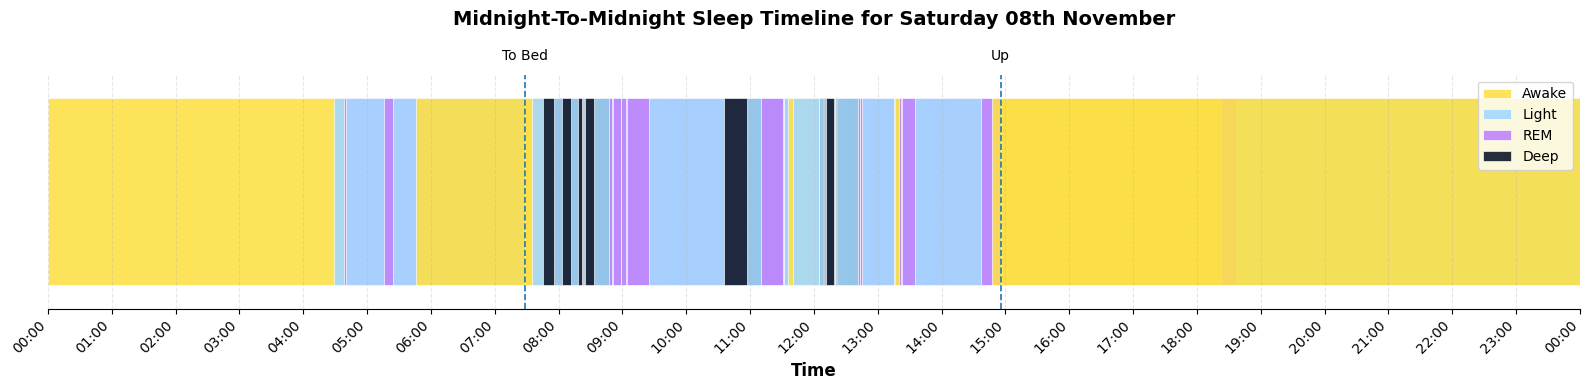

In [135]:
fig1 = plot_sleep_timeline(df_sleep_levels, df_sleep_summary)

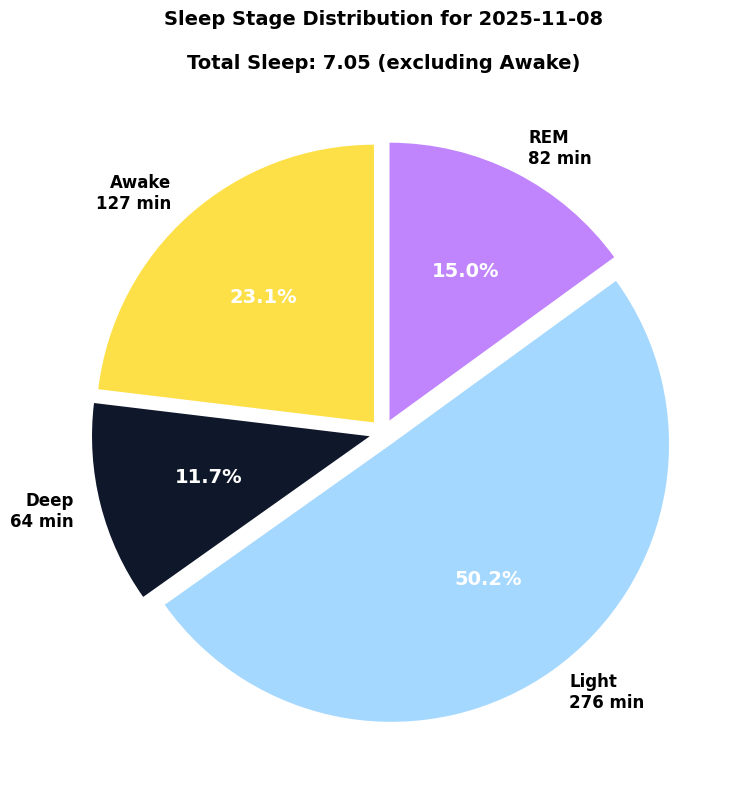

In [136]:
fig2 = plot_sleep_stages_pie(df_sleep_levels, df_sleep_summary)

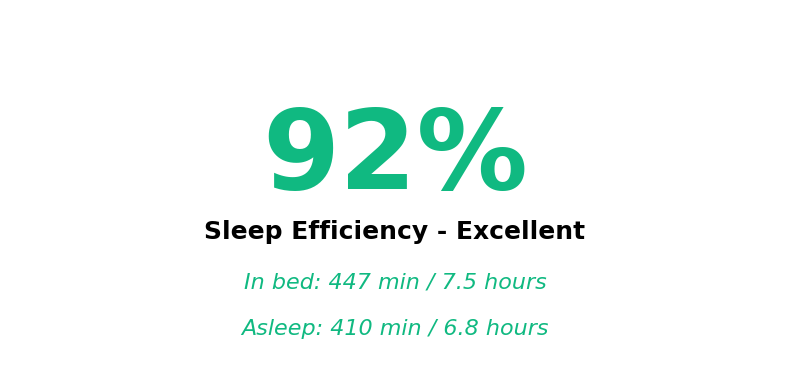

In [137]:
fig3 = display_sleep_efficiency(df_sleep_summary)

### 💤 Nap Analysis (if any)

💤 Found 1 nap(s)


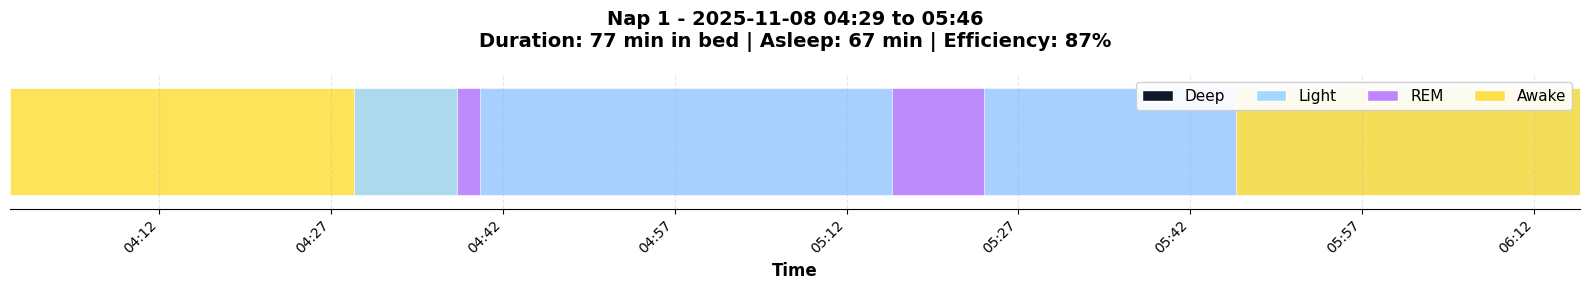

In [138]:
fig4 = plot_naps_timeline(df_sleep_levels, df_sleep_summary)

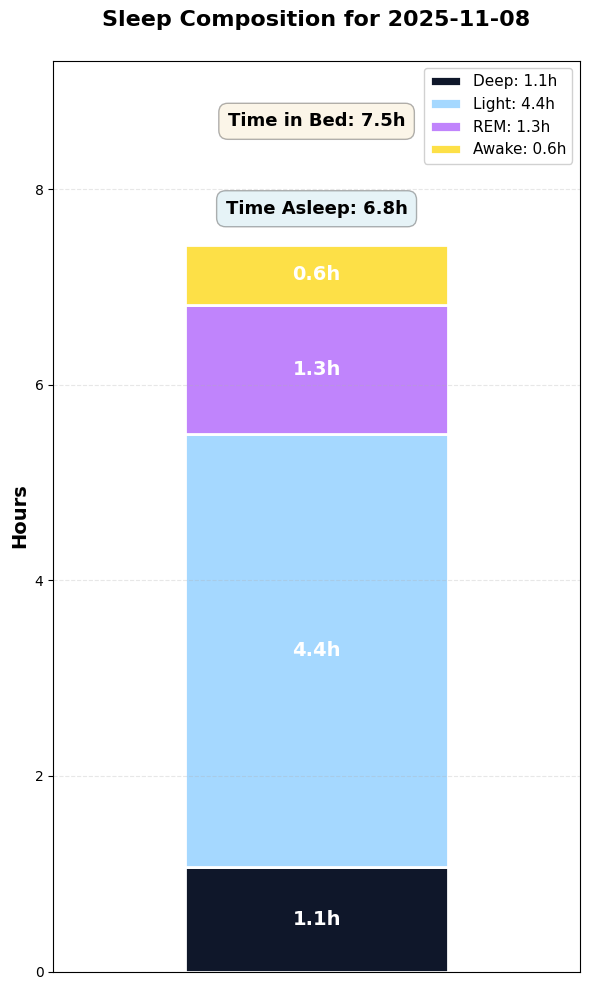

In [139]:
fig5 = plot_sleep_stages_bar(df_sleep_levels, df_sleep_summary)

💤 Found 1 nap(s)


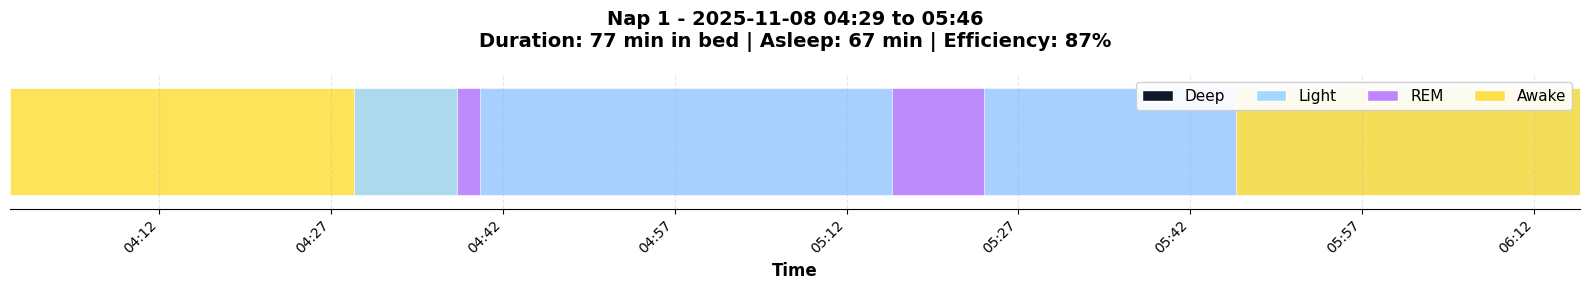

In [140]:
fig4 = plot_naps_timeline(df_sleep_levels, df_sleep_summary)